# Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [46]:
import pandas as pd
import numpy as np

#with maximum number of rows
df=pd.read_csv("data_000637.txt")
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2. Find out the number of BX in a ORBIT (the value 'x').

In [47]:
x = np.max(df['BX_COUNTER']) + 1
print(x)

3564


3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [52]:
df['absolute_time_ns'] = (df['ORBIT_CNT']*x+df['BX_COUNTER'])*25
precise = df['absolute_time_ns'].max() - df['absolute_time_ns'].min()
print("The data took",precise,"ns",", or",precise*1e-9,"s")

The data took 980416275 ns , or 0.9804162750000001 s


4. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [53]:
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time_ns
0,1,0,123,3869200167,2374,26,344745734939050
1,1,0,124,3869200167,2374,27,344745734939050
2,1,0,63,3869200167,2553,28,344745734943525
3,1,0,64,3869200167,2558,19,344745734943650
4,1,0,64,3869200167,2760,25,344745734948700
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,344746715355150
1310716,1,1,4,3869211171,763,11,344746715355175
1310717,1,0,64,3869211171,764,0,344746715355200
1310718,1,0,139,3869211171,769,0,344746715355325


5. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [77]:
df["HEAD"] = np.random.choice([0,1],len(df["HEAD"]))
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time_ns
0,1,0,123,3869200167,2374,26,344745734939050
1,1,0,124,3869200167,2374,27,344745734939050
2,0,0,63,3869200167,2553,28,344745734943525
3,1,0,64,3869200167,2558,19,344745734943650
4,1,0,64,3869200167,2760,25,344745734948700
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,344746715355150
1310716,0,1,4,3869211171,763,11,344746715355175
1310717,1,0,64,3869211171,764,0,344746715355200
1310718,0,0,139,3869211171,769,0,344746715355325


6. Create a new DataFrame that contains only the rows with HEAD=1.

In [80]:
new_df=df[df["HEAD"] == 1]
new_df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,absolute_time_ns
0,1,0,123,3869200167,2374,26,344745734939050
1,1,0,124,3869200167,2374,27,344745734939050
3,1,0,64,3869200167,2558,19,344745734943650
4,1,0,64,3869200167,2760,25,344745734948700
10,1,1,7,3869200167,2785,4,344745734949325
...,...,...,...,...,...,...,...
1310712,1,1,35,3869211171,429,4,344746715346825
1310713,1,0,64,3869211171,758,18,344746715355050
1310714,1,0,60,3869211171,762,2,344746715355150
1310715,1,0,62,3869211171,762,14,344746715355150


7. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

Text(0.5, 0, 'Channel')

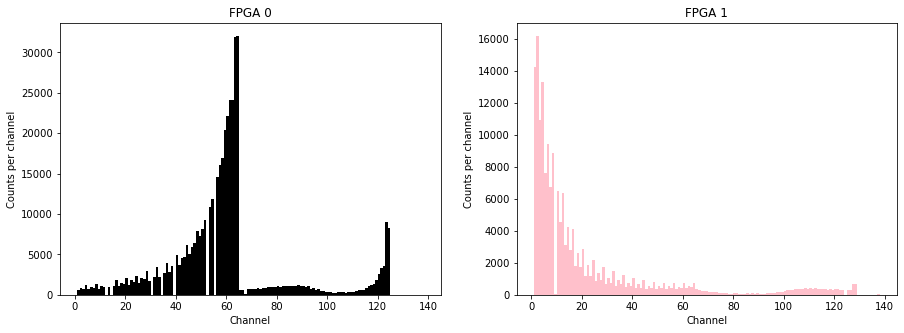

In [151]:
import matplotlib.pyplot as plt

FPGA0 = new_df[new_df['FPGA'] == 0]
FPGA1 = new_df[new_df['FPGA'] == 1]

figure, (fpga0, fpga1) = plt.subplots(1,2,figsize=(15, 5))

TDC_CHANNEL0 = FPGA0['TDC_CHANNEL']
TDC_CHANNEL1 = FPGA1['TDC_CHANNEL']

fpga0.hist( TDC_CHANNEL_0, bins=np.arange(TDC_CHANNEL_0.min(), TDC_CHANNEL_0.max()), color = "black")
fpga0.set_title('FPGA 0')
fpga0.set_ylabel("Counts per channel")
fpga0.set_xlabel("Channel")

fpga1.hist( TDC_CHANNEL_1, bins=np.arange(TDC_CHANNEL_1.min(), TDC_CHANNEL_1.max()), color = "pink")
fpga1.set_title('FPGA 1')
fpga1.set_ylabel("Counts per channel")
fpga1.set_xlabel("Channel")

8. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [152]:
df.groupby(["FPGA", "TDC_CHANNEL"])["absolute_time_ns"].count().sort_values(ascending = False).head(3)

FPGA  TDC_CHANNEL
0     139            75617
      64             64581
      63             63724
Name: absolute_time_ns, dtype: int64

9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [153]:
print("Orbit count: ", df["ORBIT_CNT"].nunique())
print("With channel 139:", df[df['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique())

Orbit count:  11001
With channel 139: 10976
